# Estimation of Distribution Algorithms

Implements an Estimation of Distribution Algorithms for fitting 1D data.

## Imports libraries

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt

## Creates Individual class with all computations

In [3]:
class Individual(object):
    def __init__(self, weights, func, X, Y):
        """
        Instantiates a new Individual.

        :param weights: Weights of the individual.
        :param func: Fitness function.
        """
        self.weights = np.array(weights, dtype=float).reshape(1, len(weights))
        self.func = func
        self.fitness = self.__fitness__(X, Y)

    def predict(self, x):
        return np.ravel(np.sign(np.dot(self.weights, x.T)))

    def __fitness__(self, X, Y):
        return self.func(self, X, Y)

    def __str__(self):
        return f'weights: {self.weights}'

    def __repr__(self):
        return f'weights: {self.weights}'

## Creates EDA class with all computations

In [4]:
class EDA(object):

    def __init__(self, selection_rate=0.5, replacement_rate=0.5, seed=None):
        """
        Builds an instance of an Estimation of Distribution Algorithm for classification.

        :param selection_rate: The rate to select the fittest individuals for any given population.
        :param replacement_rate: The rate to replace older individuals with new ones.
        :param seed: Optional - seed for the numpy.random module.
        """
        np.random.seed(seed)

        self.means = None  # type: list
        self.stds = None  # type: list
        self.selection_rate = selection_rate
        self.replacement_rate = replacement_rate

        self.id2label = None  # type: dict
        self.label2id = None  # type: dict

        self.best_individual = None  # type: Individual

    def fit(self, x_train, y_train, func, pop_size=100, gens=100):
        """
        Fits data.

        :param x_train: the input variables for the problem.
        :param y_train: the actual label for input data.
        :param func: A pointer to a fitness function, defined outside the scope of this class.
        :param pop_size: Optional - The population size. Affects memory consumption. Defaults to 100.
        :param gens: Optional - Number of iterations. Affects time spent training. Defaults to 100.
        :return: returns itself
        """
        # arrays for storing the means and standard deviations of normal distributions - one for each variable
        # adds 1 for the free parameter w0, e.g. w0 + (w1 * x1)
        if self.means is None or self.stds is None:
            self.means = np.ones(x_train.shape[1] + 1, dtype=float)
            self.stds = np.ones(x_train.shape[1] + 1, dtype=float)

        # adds 1 to input data to multiply to free parameter
        X = np.hstack((np.ones((x_train.shape[0], 1)), x_train)).astype(float)
        Y, self.label2id, self.id2label = EDA.__string_to_int__(y_train)

        n_fittest = int(np.ceil(pop_size * self.selection_rate))
        n_to_replace = int(np.ceil(pop_size * (1 - self.replacement_rate)))
        indices_to_replace = list(range(n_to_replace, pop_size))

        population, fitness = self.__sample__(pop_size, func, X, Y)

        gen = 0
        while gen < gens:
            # sorts population by ascending order based on the fitness
            population, fitness = self.__sorts_by_fitness__(population, fitness)

            # fittest individuals update means and stds
            fittest = population[:n_fittest]
            self.means, self.stds = self.__update__(fittest)

            # least fit individuals are replaced
            new_pop, new_fitness = self.__sample__(n_to_replace, func, X, Y)
            for i, k in enumerate(indices_to_replace):
                population[k] = new_pop[i]
                fitness[k] = new_fitness[i]
            gen += 1

        self.best_individual = population[np.argmin(fitness)]

        return self

    def predict(self, x):
        new_x = np.vstack((np.ones(x.shape[0]), x)).T
        return self.best_individual.predict(new_x)

    @property
    def W(self):
        return self.best_individual.weights

    def __update__(self, fittest: list):
        """
        Updates normal distributions means and standard deviations based on fittest population.

        :param fittest: Fittest population.
        """
        c_means = [[] for i in range(len(self.means))]
        for ind in fittest:
            for i in range(ind.weights.shape[1]):
                c_means[i] += [ind.weights[0, i]]

        for i in range(len(c_means)):
            self.means[i] = np.mean(c_means[i])
            self.stds[i] = np.std(c_means[i])

        return self.means, self.stds

    def __sample__(self, pop_size, func, X, Y):
        """
        Generates a sample population based on the probability array.

        :param pop_size: The size of the population to be generated.
        :return: A tuple composed of the newly sampled population and its fitness.
        """
        population = []
        fitness = []
        for i in range(pop_size):
            weights = []
            for j in range(len(self.means)):
                weights += [np.random.normal(loc=self.means[j], scale=self.stds[j])]
            ind = Individual(weights, func, X, Y)
            local_fit = ind.fitness

            population += [ind]
            fitness += [local_fit]

        return population, fitness

    @staticmethod
    def __sorts_by_fitness__(population, fitness):
        argsorted = np.argsort(fitness)
        new_pop = []
        new_fitness = []
        for index in argsorted:
            new_pop += [population[index]]
            new_fitness += [fitness[index]]

        return new_pop, new_fitness

    @staticmethod
    def __string_to_int__(Y: np.ndarray):
        values = np.unique(Y)
        id2label = {i: k for i, k in enumerate(values)}
        label2id = {k: i for i, k in id2label.items()}

        return Y, label2id, id2label

## Creates fitness function

Used to evaluate performance of individuals in the task at hand.

In [5]:
def fitness_function(ind: Individual, x_train, y_train):
    """
    Computes fitness function of an individual. The closer to zero the value, the better

    :param ind: An individual.
    :param x_train: the input variables for the problem.
    :param y_train: the actual label for input data.
    :return: The fitness of the individual
    """
    preds = []
    for x in x_train:
        preds += [ind.predict(x)]

    return mse(preds, y_train)

## Creates function for visualizing projections

In [6]:
def plot_model(fig, ax, title, model, x, y):
    x_axis = np.linspace(np.min(x), np.max(y) + 1)
    y_axis = model.predict(x_axis)

    ax.plot(x_axis, y_axis, label='h(x)', c='#7DCE82', zorder=0)
    ax.scatter(x, y, label='y', c='#3CDBD3', zorder=1)
    ax.set_title(title)
    fig.legend()

## Creates function for training and projection

In [7]:
def static_projection(x_train, y_train):
    fig, ax = plt.subplots(nrows=2)
    ax = np.ravel(ax)

    pop_size = 100
    selection_rate = 0.6
    replacement_rate = 0.4

    gens = 2
    model = EDA(selection_rate, replacement_rate)
    model = model.fit(_x_train, _y_train, func=fitness_function, pop_size=pop_size, gens=gens)
    plot_model(
        fig, ax[0],
        f'model trained for {gens} generations\nModel weights: {np.around(model.W, 2)}', model, x_train, y_train
    )

    gens = 98
    model = model.fit(_x_train, _y_train, func=fitness_function, pop_size=pop_size, gens=gens)
    plot_model(
        fig, ax[1],
        f'model trained for {gens} more generations\nModel weights: {np.around(model.W, 2)}', model, x_train, y_train
    )
    plt.tight_layout()
    plt.show()

## Creates dataset and calls function

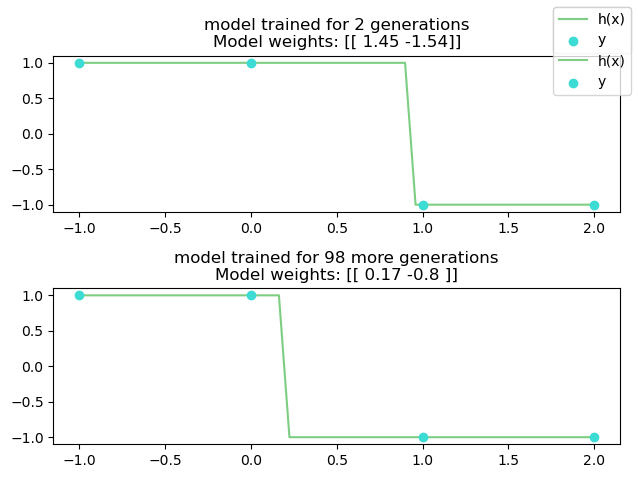

In [8]:
_x_train = np.array([1, 2, 0, -1]).reshape(4, 1)
_y_train = np.array([-1, -1, 1, 1]).reshape(4, 1)

static_projection(_x_train, _y_train)